# Hauptseminar


## imports

In [2]:
import os
import cv2
import json
import shutil
import pickle
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

from skimage import draw
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture as GMM

## display images

In [3]:
def display_img(img, convert=True, title="", size=(4, 4), show=True):
    plt.figure(figsize=size)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if convert else img)
    plt.title(title)
    plt.tight_layout()
    if show:
        plt.show()

# prepare data

In [4]:
def load(dataset, verbose=True):
    data_dir = "..\data"
    base_dir = os.path.join(data_dir, dataset)
    images_dir = os.path.join(base_dir, "images")
    skins_dir = os.path.join(base_dir, "skin")
    bodies_dir = os.path.join(base_dir, "body")
    
    images, skins, bodies = [], [], []

    for file in os.listdir(images_dir):
        images.append(cv2.imread(os.path.join(images_dir, file)))

    for file in os.listdir(skins_dir):
        skin = cv2.imread(os.path.join(skins_dir, file))
        skin = cv2.cvtColor(skin, cv2.COLOR_RGB2GRAY)
        if "THU_READ_RGBD" in dataset:
            skin = skin.astype("uint8")
        else:
            skin = (skin/255).astype("uint8")
        skins.append(skin)

    for file in os.listdir(bodies_dir):
        body = cv2.imread(os.path.join(bodies_dir, file))
        body = cv2.cvtColor(body, cv2.COLOR_RGB2GRAY)
        if "THU_READ_RGBD" in dataset:
            body = (body/255).astype("uint8")
        else:
            body = body.astype("uint8")
        bodies.append(body)

    if verbose:
        print(f"loading successful! {len(images)} images, {len(skins)} skins, {len(bodies)} bodies")
    return images, skins, bodies
        
datasets = ["THU_READ_RGBD", "THU_READ_RGBD_BODIES", "joint-ep-of-thu-ego"]
images, skins, bodies = load(dataset=datasets[1])

print(f"image {images[0].shape}")
print(f"skin {skins[0].shape} {np.unique(skins[0])}")
print(f"body {bodies[0].shape} {np.unique(bodies[0])}")

loading successful! 35 images, 35 skins, 35 bodies
image (480, 640, 3)
skin (480, 640) [0 1]
body (480, 640) [0 1]


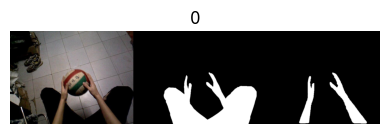

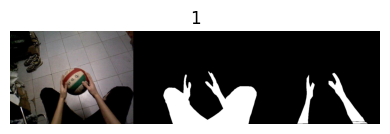

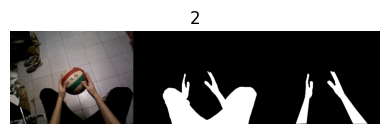

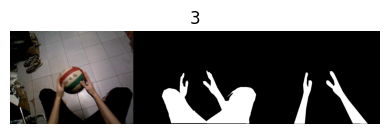

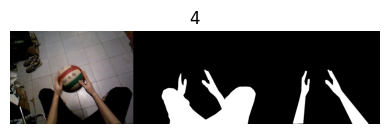

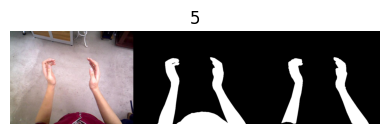

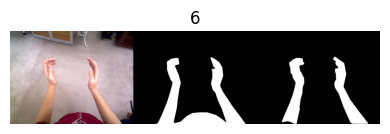

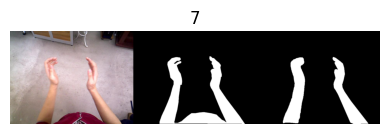

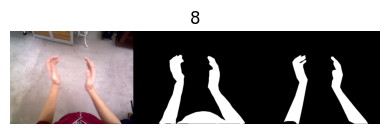

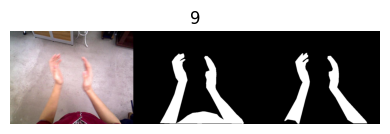

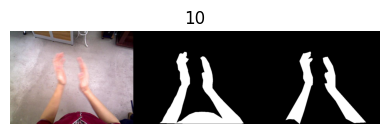

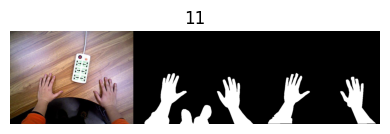

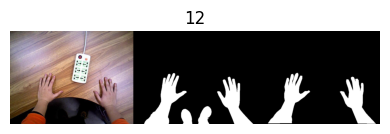

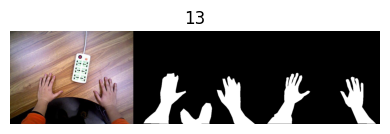

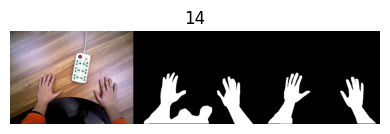

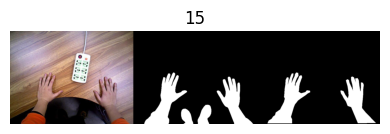

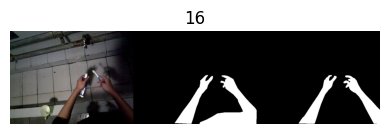

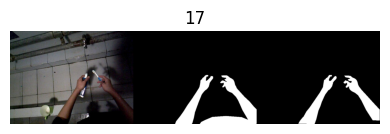

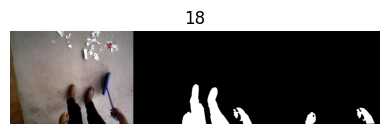

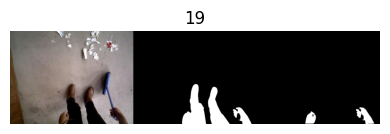

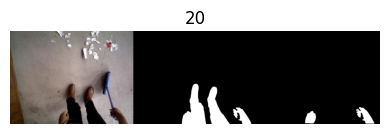

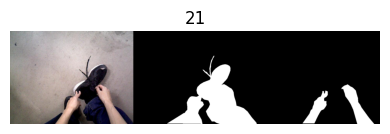

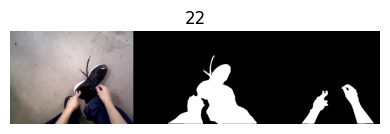

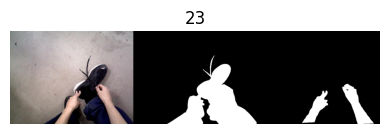

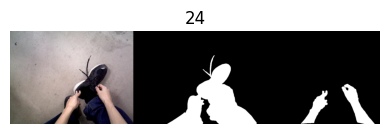

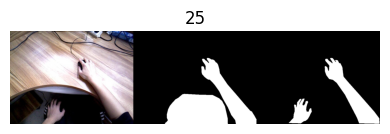

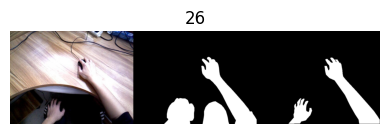

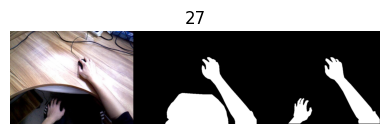

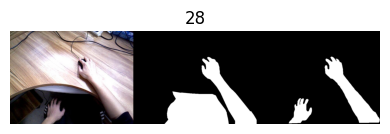

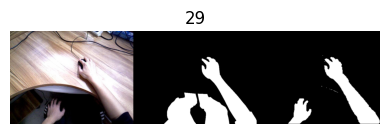

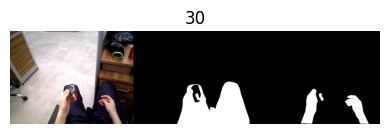

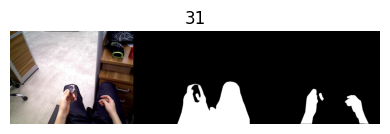

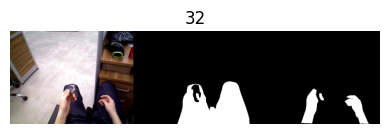

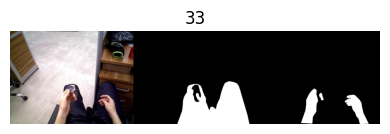

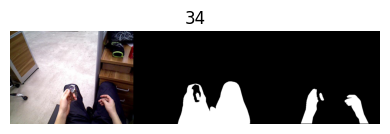

In [5]:
for i in range(len(images)):
    display_img(cv2.hconcat([images[i], cv2.cvtColor(bodies[i], cv2.COLOR_GRAY2RGB)*255, cv2.cvtColor(skins[i], cv2.COLOR_GRAY2RGB)*255]), title=f"{i}")

## get masked image

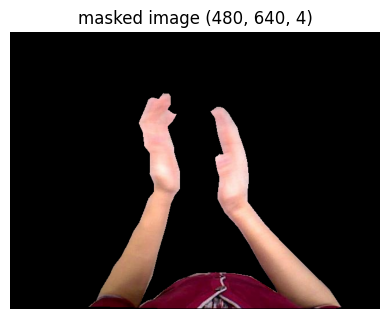

In [6]:
def get_masked_image(img_id, images, bodies, alpha=False):
    image = images[img_id].copy()
    body = bodies[img_id].copy()
    body_rgb = cv2.cvtColor(body, cv2.COLOR_GRAY2RGB)
    # apply mask
    image = image*body_rgb
#     image = cv2.bitwise_and(img, img, mask=body)
    if alpha:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
        image[:, :, 3] = body
    return image

# get img
img_id = 10
img = get_masked_image(img_id, images, bodies, alpha=True)

# display
display_img(img, title=f"masked image {img.shape}")

## get masks

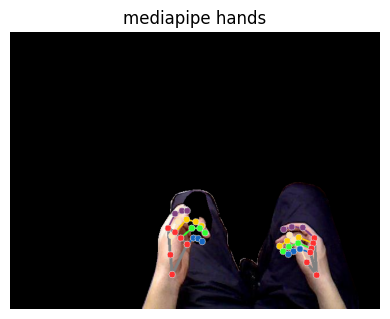

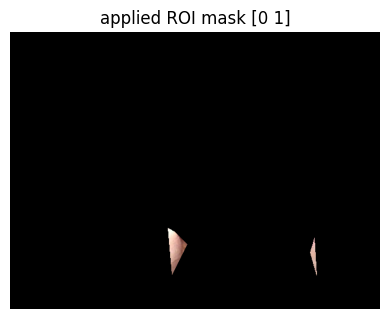

In [7]:
def get_ROI_mask(img, hands=2, draw=False):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    landmarks_dict = {
        "wrist": mp_hands.HandLandmark.WRIST,
        "index": mp_hands.HandLandmark.INDEX_FINGER_MCP,
        "middle": mp_hands.HandLandmark.MIDDLE_FINGER_MCP,
        "ring": mp_hands.HandLandmark.RING_FINGER_MCP,
        "pinky": mp_hands.HandLandmark.PINKY_MCP,
    }

    # get ROIs
    ROIs = []
    with mp_hands.Hands(static_image_mode=True, max_num_hands=hands, min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            img_height, img_width, _ = img.shape
            if draw:
                annotated_img = img.copy()
            for hand_landmarks in results.multi_hand_landmarks:
                if draw:
                    mp_drawing.draw_landmarks(annotated_img, hand_landmarks, mp_hands.HAND_CONNECTIONS, mp_drawing_styles.get_default_hand_landmarks_style(), mp_drawing_styles.get_default_hand_connections_style())
                coords = []
                for k, v in landmarks_dict.items():
                    coords.append([int(hand_landmarks.landmark[v].x*img_width), int(hand_landmarks.landmark[v].y*img_height)])
                ROIs.append(coords)
            if draw:
                display_img(annotated_img, title="mediapipe hands")
    
    # create ROI mask
    mask = np.zeros(shape=img.shape[:2], dtype=np.uint8)
    for ROI in ROIs:
        cv2.fillPoly(mask, pts=[np.array(ROI)], color=1)
    
    return mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get ROI mask
ROI_mask = get_ROI_mask(img, hands=2, draw=True)
display_img(cv2.bitwise_and(img, img, mask=ROI_mask), title=f"applied ROI mask {np.unique(ROI_mask)}")

#### RGB mask

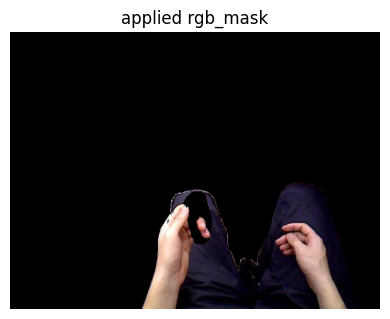

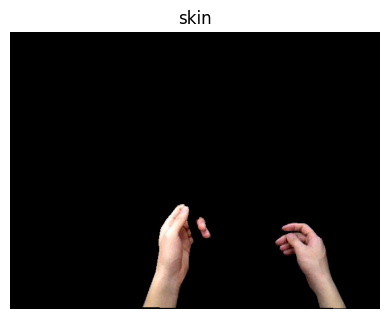

In [8]:
def get_rgb_mask(img, ROI_mask):
    # split img into luminance, chrominance
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # get ROI color values
    rgb_roi = cv2.bitwise_and(rgb, rgb, mask=ROI_mask)
    r_vals = np.unique(rgb_roi[:,:,0])
    g_vals = np.unique(rgb_roi[:,:,1])
    b_vals = np.unique(rgb_roi[:,:,2])
    
    # remove 0
    for vals in [r_vals, g_vals, b_vals]:
        vals = vals[1:] if len(vals) != 1 else vals
    
    # get min/max
    min_rgb = np.array([min(r_vals), min(g_vals), min(b_vals)])
    max_rgb = np.array([max(r_vals), max(g_vals), max(b_vals)])
    
    # create mask
    rgb_mask = cv2.inRange(rgb, min_rgb, max_rgb).astype(bool).astype("uint8")
    return rgb_mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get ROI mask
ROI_mask = get_ROI_mask(img)

# apply rgb mask
rgb_mask = get_rgb_mask(img, ROI_mask)
display_img(img*rgb_mask[:,:,np.newaxis], title="applied rgb_mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### HS mask

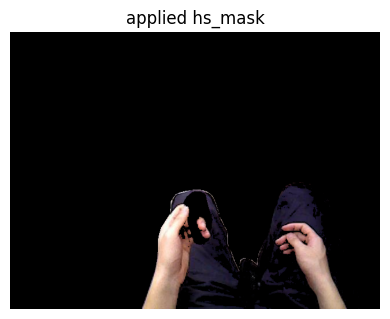

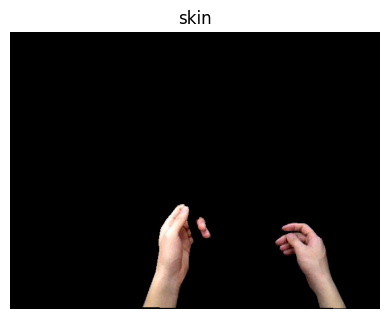

In [9]:
def get_hs_mask(img, ROI_mask):
    # split img into luminance, chrominance
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hs = hsv[:, :, [0, 1]]
    
    # get ROI color values
    hs_roi = cv2.bitwise_and(hs, hs, mask=ROI_mask)
    h_vals = np.unique(hs_roi[:,:,0])
    s_vals = np.unique(hs_roi[:,:,1])
    
    # remove masked 0
    for vals in [h_vals, s_vals]:
        vals = vals[1:] if len(vals) != 1 else vals
    
    # get min/max
    min_hs = np.array([min(h_vals), min(s_vals)])
    max_hs = np.array([max(h_vals), max(s_vals)])
    
    # create mask
    hs_mask = cv2.inRange(hs, min_hs, max_hs).astype(bool).astype("uint8")
    return hs_mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get ROI mask
ROI_mask = get_ROI_mask(img)

# apply hs mask
hs_mask = get_hs_mask(img, ROI_mask)
display_img(img*hs_mask[:,:,np.newaxis], title="applied hs_mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### CrCb mask

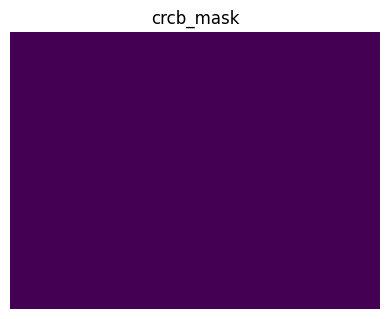

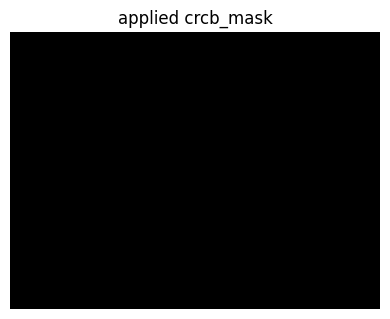

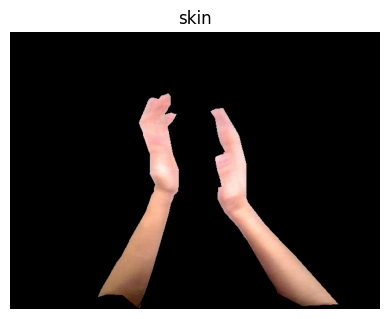

In [10]:
def get_crcb_mask(img, ROI_mask):
    # split img into luminance, chrominance
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    crcb = ycrcb[:, :, [1, 2]]
    
    # get ROI color values
    crcb_roi = cv2.bitwise_and(crcb, crcb, mask=ROI_mask)
    cr_vals = np.unique(crcb_roi[:,:,0])
    cb_vals = np.unique(crcb_roi[:,:,1])
    
    # remove masked 0
    for vals in [cr_vals, cb_vals]:
        vals = vals[1:] if len(vals) != 1 else vals
    
    # get min/max
    min_crcb = np.array([min(cr_vals), min(cb_vals)])
    max_crcb = np.array([max(cr_vals), max(cb_vals)])
    
    # create mask
    crcb_mask = cv2.inRange(crcb, min_crcb, max_crcb).astype(bool).astype("uint8")
    return crcb_mask

# get img
img_id = 10
img = get_masked_image(img_id, images, bodies)

# get ROI mask
ROI_mask = get_ROI_mask(img)

# apply crcb mask
crcb_mask = get_crcb_mask(img, ROI_mask)
display_img(crcb_mask, convert=False, title="crcb_mask")
display_img(img*crcb_mask[:,:,np.newaxis], title="applied crcb_mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### lum mask

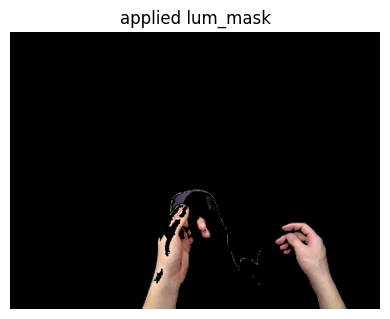

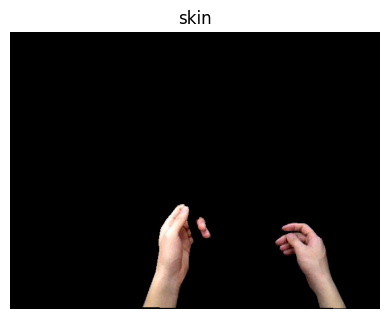

In [11]:
def get_lum_mask(img, ROIs, lum_method=0):
    # split img into luminance, chrominance
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    lum = ycbcr[:,:,0]
    
    # get luminance at ROIs
    lum_list = np.array(cv2.bitwise_and(lum, lum, mask=ROI_mask).flatten())    
    lum_list = lum_list[lum_list != 0]
        
    if lum_method == 0:
        mean_lum = sum(lum_list)/len(lum_list)
        span_lum = max(lum_list)-min(lum_list)

        bot = max(0, mean_lum-span_lum/2)
        top = min(mean_lum+span_lum/4, 255)

        # apply luminance thresholds
        lum_mask = cv2.inRange(lum, bot, top).astype(bool).astype("uint8")
    else:
        min_lum = min(lum_list)
        max_lum = max(lum_list)

        # apply luminance thresholds
        _, min_lum = cv2.threshold(lum, min_lum, 255, cv2.THRESH_BINARY)
        _, max_lum = cv2.threshold(lum, max_lum, 255, cv2.THRESH_BINARY_INV)
        lum_mask = cv2.bitwise_and(min_lum, max_lum).astype(bool).astype("uint8")
    return lum_mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get ROI mask
ROI_mask = get_ROI_mask(img)

# apply lum mask
lum_mask = get_lum_mask(img, ROI_mask, lum_method=0)
display_img(img*lum_mask[:,:,np.newaxis], title="applied lum_mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### Otsu's thresholding

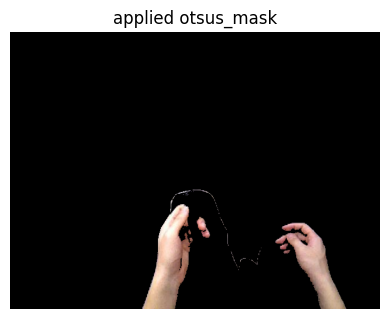

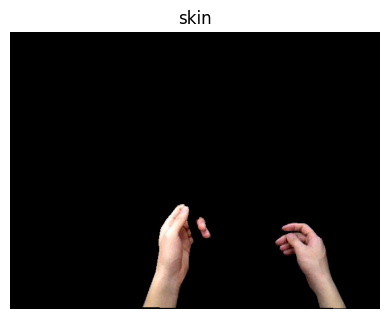

In [12]:
def get_otsus_mask(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # apply otsu's thresholding
    threshold, otsus_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsus_mask = otsus_mask.astype(bool).astype("uint8")
    
    return otsus_mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# apply otsus mask
otsus_mask = get_otsus_mask(img)
display_img(img*otsus_mask[:,:,np.newaxis], title="applied otsus_mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### chroma in range of [0.0425,0.125]

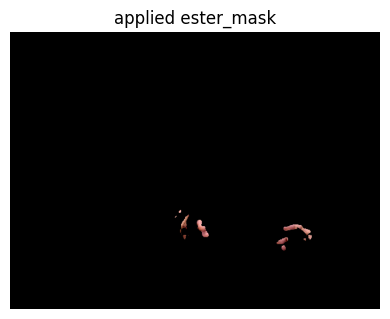

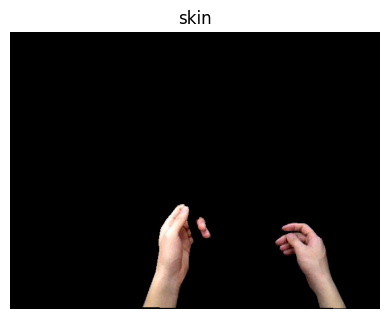

In [13]:
def get_ester_mask(img, c0=0.0425, c1=0.125):  # c0 = 0.0625
    def imchroma(rgb, c0, c1):
        Pr = rgb * [0.5, -0.418688, -0.081312] / 255.
        out = np.clip(np.sum((Pr - c0) / (c1 - c0), axis=-1), 0, 1)
    #     out = out.astype(bool).astype("uint8")
        return out

    def add_mask(image, mask):
        b_channel, g_channel, r_channel = cv2.split(image)
        alpha_channel = mask*255

        alpha_channel = alpha_channel.astype(np.float64)

        g_channel_out = np.clip(np.add(alpha_channel, g_channel), 0, 255)
        g_channel_out = g_channel_out.astype(np.uint8)

        alpha_channel = alpha_channel.astype(np.uint8)
        img_BGRA = cv2.merge((b_channel, g_channel_out, r_channel, alpha_channel))
        image_RGBA = cv2.cvtColor(img_BGRA, cv2.COLOR_BGRA2RGBA)

        return image_RGBA, alpha_channel

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = imchroma(img, c0, c1)
    masked_im, mask = add_mask(img, mask)

    mask = np.where(mask==0, 0, 1).astype("uint8")

    return mask.astype("uint8")

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# apply ester mask
ester_mask = get_ester_mask(img)
display_img(img*ester_mask[:,:,np.newaxis], title="applied ester_mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### madrid algorithm  -  thresholds based on peaks of histograms

In [14]:
import cv2
import mediapipe as mp
import argparse
from glob import glob
import os
import time
import matplotlib.pyplot as plt
from scipy import signal

import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", required=False, default='/home/user/Desktop/NOKIA/week1411-2011/val_for_Luis/val_for_Luis/000-033/img/',
                    help="path to input images folder")
ap.add_argument("-l", "--labels", required=False, default='/home/user/Desktop/NOKIA/week1411-2011/val_for_Luis/val_for_Luis/000-033/infer_labels/',
                help="path to labels images folder")
args = vars(ap.parse_args())


def hands_det(img, infer_label):
    image_height, image_width, _ = img.shape
    infer_mask = np.uint8(infer_label)
    with mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=4,
            min_detection_confidence=0.5) as hands:
        # Convert the BGR image to RGB before processing.
        # img = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # image.flags.writeable = False
        results = hands.process(img)
        annotated_image = img.copy()
        hands_rg = np.zeros_like(img)
        hands_mask = np.zeros_like(img[:, :, 0])

        if results.multi_hand_landmarks:
            landmarks = {}
            for hand_landmarks in results.multi_hand_landmarks:
                # Here is How to Get All the Coordinates
                for ids, landmrk in enumerate(hand_landmarks.landmark):

                    cx, cy = int(landmrk.x * image_width), int(landmrk.y * image_height)
                    #print(ids, cx, cy)
                    landmarks[ids] = (cx, cy)
                    if ids == 0:
                        cv2.circle(hands_rg, (cx, cy), radius=20, color=(255, 0, 0), thickness=-1)

                    elif ids==4 or ids == 20 or ids == 8 or ids == 16 or ids == 12 or ids == 7 or ids==11 or ids==3 or ids==15 or ids==19:
                        cv2.circle(hands_rg, (cx, cy), radius=2, color=(255, 0, 0), thickness=-1)
                    else:
                        cv2.circle(hands_rg, (cx, cy), radius=5, color=(255, 0, 0), thickness=-1)

                # Draw lines in the palms
                cv2.line(hands_rg, (landmarks[0]), (landmarks[1]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[5]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[9]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[13]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[17]), color=(0, 255, 0), thickness=6)



                # Draw lines between knuckles
                cv2.line(hands_rg, (landmarks[5]), (landmarks[9]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[9]), (landmarks[13]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[13]), (landmarks[17]), color=(0, 255, 0), thickness=6)

                cnt1= np.array([[landmarks[0], landmarks[17], landmarks[13]]])
                cnt2 = np.array([landmarks[0], landmarks[9], landmarks[13]])
                cnt3 = np.array([landmarks[0], landmarks[5], landmarks[9]])
                cnt4 = np.array([landmarks[0], landmarks[5], landmarks[1]])
                cnt5 = np.array([landmarks[2], landmarks[5], landmarks[1]])
                cv2.drawContours(hands_rg, [cnt1], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt2], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt3], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt4], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt5], 0, (0, 255, 0), -1)

                # Draw lines in the fingers
                #for i in range(1, 4):
                for i in range(1, 3):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(5, 8):
                for i in range(5, 7):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(9, 12):
                for i in range(9, 11):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(13, 16):
                for i in range(13, 15):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(17, 20):
                for i in range(17, 19):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)

            hands_mask = np.uint8(np.where((hands_rg[:, :, 0] == 255) | (hands_rg[:, :, 1] == 255), 1, 0))
            final_mask = np.uint8(infer_mask & hands_mask)
            #final_mask = hands_mask
            hands_rgb = np.zeros_like(img)
            hands_rgb[:, :, 0] = np.where(final_mask == 1, img[:, :, 0], 0)
            hands_rgb[:, :, 1] = np.where(final_mask == 1, img[:, :, 1], 0)
            hands_rgb[:, :, 2] = np.where(final_mask == 1, img[:, :, 2], 0)
            return hands_rgb, final_mask, 1

        if not results.multi_hand_landmarks:
            return np.zeros_like(img), np.zeros_like(img[:, :, 0]), 0

# This function approximates with a normal distribution the skin color information of Cb and Cr color channels
# It obtains the mean and standard deviation of skin color within the image to define the gaussian
def gaussian_model(image_bgr, hands_mask):
    image_ycrcb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)

    mean_cr = np.mean(image_ycrcb[:,:,1][hands_mask==1].flatten())
    mean_cb = np.mean(image_ycrcb[:,:,2][hands_mask==1].flatten())
    std_cr = np.std(image_ycrcb[:,:, 1][hands_mask == 1].flatten())
    std_cb = np.std(image_ycrcb[:,:, 2][hands_mask == 1].flatten())


    return mean_cr, std_cr, mean_cb, std_cb

# This function classifies as foreground the pixels that fall inside the approximated normal distribution
def gaussian_classif(image_bgr, mean_cr, std_cr, mean_cb, std_cb, alpha):
    mask_cr = np.where(abs(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:,:,1]-mean_cr) < alpha*std_cr, 1,0)
    mask_cb = np.where(abs(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:,:,2] - mean_cb) < alpha*std_cb, 1, 0)
    return mask_cr & mask_cb



# Next function objective is to obtain color parameters (mean and std) separately from the different cameras of the stereo
def gaussian_model(image_bgr, hands_mask, side):
    image_ycrcb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)
    if side=="left":
        mean_cr = np.mean(image_ycrcb[:,0:int(image_bgr.shape[1]/2+1),1][hands_mask==1].flatten())
        mean_cb = np.mean(image_ycrcb[:,0:int(image_bgr.shape[1]/2+1),2][hands_mask==1].flatten())
        std_cr = np.std(image_ycrcb[:,0:int(image_bgr.shape[1]/2+1), 1][hands_mask == 1].flatten())
        std_cb = np.std(image_ycrcb[:,0:int(image_bgr.shape[1]/2+1), 2][hands_mask == 1].flatten())

    elif side=="right":
        mean_cr = np.mean(image_ycrcb[:, int(image_bgr.shape[1]/2+1):int(image_bgr.shape[1]+1), 1][hands_mask == 1].flatten())
        mean_cb = np.mean(image_ycrcb[:, int(image_bgr.shape[1]/2+1):int(image_bgr.shape[1]+1), 2][hands_mask == 1].flatten())
        std_cr = np.std(image_ycrcb[:,int(image_bgr.shape[1]/2+1):int(image_bgr.shape[1]+1),1][hands_mask==1].flatten())
        std_cb = np.std(image_ycrcb[:,int(image_bgr.shape[1]/2+1):int(image_bgr.shape[1]+1),2][hands_mask==1].flatten())

    return mean_cr, std_cr, mean_cb, std_cb


# It classifies pixels from both cameras separately
def gaussian_classif(image_bgr, mean_cr_l, std_cr_l, mean_cb_l, std_cb_l, mean_cr_r, std_cr_r, mean_cb_r, std_cb_r, alpha):
    mask_cr_l = np.where(abs(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:,0:int(image_bgr.shape[1]/2+1),1]-mean_cr_l) < alpha*std_cr_l, 1,0)
    mask_cb_l = np.where(abs(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:,0:int(image_bgr.shape[1]/2+1),2] - mean_cb_l) < alpha*std_cb_l, 1, 0)

    mask_cr_r = np.where(abs(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:, int(image_bgr.shape[1]/2+1):int(image_bgr.shape[1]+1), 1] - mean_cr_r) < alpha * std_cr_r, 1, 0)
    mask_cb_r = np.where(abs(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:, int(image_bgr.shape[1]/2+1):int(image_bgr.shape[1]+1), 2] - mean_cb_r) < alpha * std_cb_r, 1, 0)

    return cv2.hconcat([(mask_cr_l & mask_cb_l) , (mask_cr_r & mask_cb_r)])


# Fixed thresholds classification
def fixed_thresh_ycrcb(image_bgr):
    mask_cr = np.where((cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:, :, 1] > 135) & (cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:, :, 1] < 170), 1, 0)
    mask_cb = np.where((cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:, :, 2] > 100) & (cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)[:, :, 2] < 125), 1, 0)
    return mask_cr & mask_cb

usage: ipykernel_launcher.py [-h] [-i INPUT] [-l LABELS]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\h.raible\AppData\Roaming\jupyter\runtime\kernel-eec2caf9-fd4d-4acd-8432-4af1ab27bb54.json


SystemExit: 2

C:\ProgramData\Anaconda3\envs\hauptseminar\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import argparse
import time
from glob import glob
from scipy import signal


# This function detects the hands within the image using Mediapipe library
# Needs image in RGB and the DL inferred label as input
# Outputs:
# hands_rgb = an image only containing the hands in RGB
# final_mask = mask of the hands
def hands_det(img_rgb, infer_label):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    image_height, image_width, _ = img_rgb.shape
    infer_mask = np.uint8(infer_label)
    with mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=4,
            min_detection_confidence=0.5) as hands:

        # image.flags.writeable = False
        results = hands.process(img_rgb)
        annotated_image = img_rgb.copy()
        hands_rg = np.zeros_like(img_rgb)
        hands_mask = np.zeros_like(img_rgb[:, :, 0])

        if results.multi_hand_landmarks:
            landmarks = {}
            for hand_landmarks in results.multi_hand_landmarks:
                # Here is How to Get All the Coordinates
                for ids, landmrk in enumerate(hand_landmarks.landmark):

                    cx, cy = int(landmrk.x * image_width), int(landmrk.y * image_height)
                    #print(ids, cx, cy)
                    landmarks[ids] = (cx, cy)
                    if ids == 0:
                        cv2.circle(hands_rg, (cx, cy), radius=20, color=(255, 0, 0), thickness=-1)

                    elif ids==4 or ids == 20 or ids == 8 or ids == 16 or ids == 12 or ids == 7 or ids==11 or ids==3 or ids==15 or ids==19:
                        cv2.circle(hands_rg, (cx, cy), radius=2, color=(255, 0, 0), thickness=-1)
                    else:
                        cv2.circle(hands_rg, (cx, cy), radius=5, color=(255, 0, 0), thickness=-1)

                # Draw lines in the palms
                cv2.line(hands_rg, (landmarks[0]), (landmarks[1]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[5]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[9]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[13]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[17]), color=(0, 255, 0), thickness=6)

                # Draw lines between knuckles
                cv2.line(hands_rg, (landmarks[5]), (landmarks[9]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[9]), (landmarks[13]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[13]), (landmarks[17]), color=(0, 255, 0), thickness=6)

                cnt1= np.array([[landmarks[0], landmarks[17], landmarks[13]]])
                cnt2 = np.array([landmarks[0], landmarks[9], landmarks[13]])
                cnt3 = np.array([landmarks[0], landmarks[5], landmarks[9]])
                cnt4 = np.array([landmarks[0], landmarks[5], landmarks[1]])
                cnt5 = np.array([landmarks[2], landmarks[5], landmarks[1]])
                cv2.drawContours(hands_rg, [cnt1], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt2], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt3], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt4], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt5], 0, (0, 255, 0), -1)

                # Draw lines in the fingers
                #for i in range(1, 4):
                for i in range(1, 3):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(5, 8):
                for i in range(5, 7):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(9, 12):
                for i in range(9, 11):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(13, 16):
                for i in range(13, 15):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(17, 20):
                for i in range(17, 19):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)

            hands_mask = np.uint8(np.where((hands_rg[:, :, 0] == 255) | (hands_rg[:, :, 1] == 255), 1, 0))
            final_mask = np.uint8(infer_mask[:,:] & hands_mask)
            #final_mask = hands_mask
            hands_rgb = np.zeros_like(img_rgb)
            hands_rgb[:, :, 0] = np.where(final_mask == 1, img_rgb[:, :, 0], 0)
            hands_rgb[:, :, 1] = np.where(final_mask == 1, img_rgb[:, :, 1], 0)
            hands_rgb[:, :, 2] = np.where(final_mask == 1, img_rgb[:, :, 2], 0)
            return hands_rgb, final_mask, 1

        if not results.multi_hand_landmarks:
            return np.zeros_like(img_rgb), np.zeros_like(img_rgb[:, :, 0]), 0


# This function obtains the color thresholds of the detected hands in the desired color space
# This is performed by setting intervals centered at the most relevant peaks of the histograms of 3 color channels
# returns 3 lists containing the 3 sets of thresholds (one per color component)
def get_color_thres_new(hands_rgb, mask_hands, color_space):
    # Parameters  needed:
    # hands_rgb: it is the part of the image which contains the hands only. It is needed to analyse its histograms and find its peaks
    # mask_hands: necesarry for the function cv2.calcHist. Thanks to applying this masks, only the pixels within this mask will be analysed
    # color_space: to select the color space in which the segmentation is going to be carried out
    if color_space == "hsv":
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2HSV)
    elif (color_space == "lab"):
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2Lab)
    elif (color_space == "ycrcb"):
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2YCrCb)
    elif (color_space == "hcrb"):
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2HSV)
        handscrcb = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2YCrCb)
        # hands[:, :, 0] = handsh[:, :, 0]
        hands[:, :, 1] = handscrcb[:, :, 1]
        hands[:, :, 2] = handscrcb[:, :, 2]

    # Obtaining histograms for each component of the color_space and their peaks for the hands ONLY (pixels within hand_mask area)
    # For Y componenet, the distance is taken into account because there are a lot of peaks in a continuous distribution along x axis
    # So, it is better to collect less peaks, but covering all the range with the purpose of not losing info
    # The "umbral" parameter is the distance from the peak to stablish the upper and lower limits. The value used later is 10
    # Therefore, with a value of distance=19, asssuming a continuous distribution, all values are covered
    firstF = cv2.calcHist([hands], [0], mask_hands, [256], [0, 256])
    peaksfirst = signal.find_peaks(np.concatenate(([min(firstF.flatten())], firstF.flatten(), [min(firstF.flatten())])),distance=10, height=100)

    # For Cr and Cb, prominence is used, as the color is well concentrated in a small range of color
    secF = cv2.calcHist([hands], [1], mask_hands, [256], [0, 256])
    peakssec = signal.find_peaks(np.concatenate(([min(secF.flatten())], secF.flatten(), [min(secF.flatten())])), prominence=75)
    thirdF = cv2.calcHist([hands], [2], mask_hands, [256], [0, 256])
    peaksthird = signal.find_peaks(np.concatenate(([min(thirdF.flatten())], thirdF.flatten(), [min(thirdF.flatten())])), prominence=75)

    # Stablishing superior and inferior thresholds centered in each peak of each color component (with a total width of 2*umbral)
    thresholds1 = []
    umbral = 10
    for i in range(len(peaksfirst[0])):
        thresholds1.append([np.clip(peaksfirst[0][i] - 20, 0, 255), np.clip(peaksfirst[0][i] + 20, 0, 255)])

    thresholds2 = []
    for i in range(len(peakssec[0])):
        thresholds2.append([np.clip(peakssec[0][i] - umbral, 0, 255), np.clip(peakssec[0][i] + umbral, 0, 255)])

    thresholds3 = []
    for i in range(len(peaksthird[0])):
        thresholds3.append([np.clip(peaksthird[0][i] - umbral, 0, 255), np.clip(peaksthird[0][i] + umbral, 0, 255)])

    return thresholds1, thresholds2, thresholds3


# This function segments by color the image by using the found thresholds
# Returns a mask which contains the pixels whose color information lies within all thresholds
def segment_skin_by_thresh(image_rgb, thresholds1, thresholds2, thresholds3, color_space):
    if color_space == "hsv":
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    if (color_space == "lab"):
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

    elif (color_space == "ycrcb"):
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)

    elif (color_space == "hcrb"):
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
        imagecrcb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)
#         image[:, :, 0] = imageh[:, :, 0]
        image[:, :, 1] = imagecrcb[:, :, 1]
        image[:, :, 2] = imagecrcb[:, :, 2]

    # We take the pixels whose color is within any of the thresholds of the set of the first color component (e.g Hue)
    mask1 = np.zeros_like(image[:, :, 0], dtype='uint8')
    for i in range(len(thresholds1)):
        maski = np.where((image[:, :, 0] <= thresholds1[i][1]) & (image[:, :, 0] >= thresholds1[i][0]), 1, 0)
        mask1 = maski | mask1

    # We take the pixels whose color is within any of the thresholds of the set of the second color component (e.g Saturation)
    mask2 = np.zeros_like(image[:, :, 1], dtype='uint8')
    for i in range(len(thresholds2)):
        maski = np.where((image[:, :, 1] <= thresholds2[i][1]) & (image[:, :, 1] >= thresholds2[i][0]), 1, 0)
        mask2 = maski | mask2

    # We take the pixels whose color is within any of the thresholds of the set of the thrid color component (e.g Value)
    mask3 = np.zeros_like(image[:, :, 2], dtype='uint8')
    for i in range(len(thresholds3)):
        maski = np.where((image[:, :, 2] <= thresholds3[i][1]) & (image[:, :, 2] >= thresholds3[i][0]), 1, 0)
        mask3 = maski | mask3

    # Return the intersection of the three masks (pixels whose color is within the thresholds of the all three masks)
    return mask1 & mask2 & mask3

In [ ]:
def get_madrid_mask(img, infer_label, color_space):   
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # This function detects the hands within the image using Mediapipe library
    # Needs image in RGB and the DL inferred label as input
    # Outputs:
    # hands_rgb = an image only containing the hands in RGB
    # final_mask = mask of the hands
    hands_rgb, mask_hands, success = hands_det(img_rgb, infer_label)

    # This function obtains the color thresholds of the detected hands in the desired color space
    # This is performed by setting intervals centered at the most relevant peaks of the histograms of 3 color channels
    # returns 3 lists containing the 3 sets of thresholds (one per color component)
    thresholds1, thresholds2, thresholds3 = get_color_thres_new(hands_rgb, mask_hands, color_space)

    # This function segments by color the image by using the found thresholds
    # Returns a mask which contains the pixels whose color information lies within all thresholds
    mask = segment_skin_by_thresh(img_rgb, thresholds1, thresholds2, thresholds3, color_space)
        
    return mask.astype("uint8")
    
# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)
# img = images[img_id].copy()

# get label
body = bodies[img_id].copy()

# apply madrid_mask
color_spaces = ["hsv", "lab", "ycrcb", "hcrb"]
results = []
for color_space in color_spaces:
    madrid_mask = get_madrid_mask(img, body, color_space)
    display_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)*madrid_mask[:,:,np.newaxis], convert=False, title=f"applied madrid_mask ({color_space})")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### combine masks

In [ ]:
def get_combined_mask(img, ROI_mask, body, baseline=False, rgb=False, hs=False, crcb=False, hsv=False, lum=False, lum_method=0, otsus=False, ester=False, madrid=False, m_cspace=0, display=False):
    # get masks
    title = []
    masks = []
    if baseline:
        title.append("baseline")
        masks.append(body)
    if rgb:
        title.append("rgb")
        masks.append(get_rgb_mask(img, ROI_mask))
    if hsv:
        title.append("hsv")
        masks.append(get_hsv_mask(img, ROI_mask))
    if hs:
        title.append("hs")
        masks.append(get_hs_mask(img, ROI_mask))
    if crcb:
        title.append("crcb")
        masks.append(get_crcb_mask(img, ROI_mask))
    if lum:
        title.append("lum")
        masks.append(get_lum_mask(img, ROI_mask, lum_method=lum_method))
    if otsus:
        title.append("otsus")
        masks.append(get_otsus_mask(img))
    if ester:
        title.append("ester")
        masks.append(get_ester_mask(img))
    if madrid:
        color_spaces = ["hsv", "lab", "ycrcb", "hcrb"]
        title.append("madrid")
        masks.append(get_madrid_mask(img, body, color_spaces[m_cspace]))

    if display:
        display_img(cv2.hconcat(masks), convert=False, title=", ".join(title))
        
    # merge masks
    combined_mask = masks[0]
    for mask in masks[1:]:
        combined_mask = cv2.bitwise_and(combined_mask, mask)
    return combined_mask

# get img
img_id = 10
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)

# apply combined mask
combined_mask = get_combined_mask(img, ROI_mask, body, rgb=True, hs=True, crcb=True, otsus=True, display=True)
display_img(img.copy()*combined_mask[:,:,np.newaxis], title="applied combined mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### recheck mask with ROIs, adjust if necessary

In [ ]:
def recheck_mask_with_ROIs(img, mask, ROI_mask, body):
    # get connected components
    n, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    # match with ROIs
    matches = np.unique(labels[ROI_mask == 1].flatten())

    # combine masks
    mask = None
    for i in set(matches):
        # skip background
        if i == 0:
            continue
        # merge mask for matching components
        if mask is None:
            mask = np.where(labels==i, 1, 0).astype("uint8")
        else:
            mask = cv2.bitwise_or(mask, np.where(labels==i, 1, 0).astype("uint8"))
            mask = cv2.bitwise_and(mask, body)
    
    # recheck with label
    if mask is not None:
        mask = cv2.bitwise_and(mask, body)
    return mask

# get img
img_id = 10
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)
# display_img(ROI_mask, title="ROI mask")

# get mask
mask = get_combined_mask(img, ROI_mask, body, crcb=True)
# display_img(mask, convert=False, title="mask")

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied mask")

# recheck
mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)
# display_img(mask, convert=False, title="rechecked mask")

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied rechecked mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### fill holes in mask

In [ ]:
def fill_mask_holes(mask):
    if mask is not None:
        h, w = mask.shape
        canvas = np.zeros((h+2, w+2), np.uint8)
        canvas[1:h+1, 1:w+1] = mask.copy()

        mask_tmp = np.zeros((h+4, w+4), np.uint8)

        cv2.floodFill(canvas, mask_tmp, (0, 0), 1)
        canvas = canvas[1:h+1, 1:w+1].astype(bool)
        return (~canvas | mask.astype(np.uint8))
    else:
        return None

# get img
img_id = 10
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)

# get mask
mask = get_combined_mask(img, ROI_mask, body, crcb=True)

# recheck
mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)
display_img(mask, convert=False, title="rechecked mask")

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied rechecked mask")

# fill holes in mask
mask = fill_mask_holes(mask)
display_img(mask, convert=False, title="filled mask")

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied filled mask")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

#### correct mask using grabcut

In [ ]:
def get_grabcut_mask(img, mask, body, iter_count=1):
    if mask is not None:
        # convert mask
        grabcut_mask = np.where((mask==1), 1, 2).astype("uint8")
        grabcut_mask[body == 0] = 0

        # create placeholders
        bgdModel = np.zeros((1,65), np.float64)
        fgdModel = np.zeros((1,65), np.float64)

        # apply grabcut
        grabcut_mask, bgdModel, fgdModel = cv2.grabCut(
                img=img, mask=grabcut_mask, rect=None,
                bgdModel=bgdModel, fgdModel=fgdModel,
                iterCount=iter_count, mode=cv2.GC_INIT_WITH_MASK)
        # return mask
        grabcut_mask = np.where((grabcut_mask==2)|(grabcut_mask==0), 0, 1).astype("uint8")
        return grabcut_mask
    else:
        return None

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)

# get mask
mask = get_combined_mask(img, ROI_mask, body, madrid=True, m_cspace=3)

# recheck
mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

# fill holes in mask
mask = fill_mask_holes(mask)
# display_img(mask, convert=False, title="filled mask")
display_img(img.copy()*mask[:,:,np.newaxis], title="applied filled mask")

# apply grabcut mask
iter_count = 2
grabcut_mask = get_grabcut_mask(img, mask, body, iter_count)
# display_img(grabcut_mask, convert=False, title="grabcut mask")
display_img(img.copy()*grabcut_mask[:,:,np.newaxis], title=f"applied grabcut mask ({i})")
display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

## complete pipeline

In [ ]:
for img_id in range(len(images)):
    # get img
#     img_id = 30
    print(img_id)
    img = get_masked_image(img_id, images, bodies)

    # get label
    body = bodies[img_id].copy()

    # get ROI mask
    ROI_mask = get_ROI_mask(img)

    # MODES
    modes = ["mask", "applied mask", "None"]
    mode = modes[2]

#     display_img(img)

    # get mask
    mask = get_combined_mask(img, ROI_mask, body, crcb=True)
    if mode == modes[0]:
        display_img(mask, convert=False, title="combined mask")
    elif mode == modes[1]:
        display_img(img.copy()*mask[:,:,np.newaxis], title="applied combined mask")

    # recheck ROIs
    mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)
    if mode == modes[0]:
        display_img(mask, convert=False, title="rechecked mask")
    elif mode == modes[1]:
        display_img(img.copy()*mask[:,:,np.newaxis], title="applied rechecked mask")

    # fill holes
    mask = fill_mask_holes(mask)
    if mode == modes[0]:
        display_img(mask, convert=False, title="filled mask")
    elif mode == modes[1]:
        display_img(img.copy()*mask[:,:,np.newaxis], title="applied filled mask")

    # apply grabcut
    iter_count = 10
    mask = get_grabcut_mask(img, mask, body, iter_count=iter_count)
    if mode == modes[0]:
        display_img(mask, convert=False, title=f"grabcut mask (i={iter_count})")
    elif mode == modes[1]:
        display_img(img.copy()*mask[:,:,np.newaxis], title=f"applied grabcut mask (i={iter_count})")
        
    display_img(mask, convert=False, title=f"grabcut mask (i={iter_count})")

    # display label
    if mode == modes[0]:
        display_img(label, convert=False, title="label")
    elif mode == modes[1]:
        display_img(img*skins[img_id][:,:,np.newaxis], title="skin")

# WIP

#### k-means clustering

## TODO: try kmeans with k=2 on deep learning model output, one centroid on hand ROI, one centroid as far as possible inside segmentation

In [21]:
# # get img
# img_id = 5
# img = get_masked_image(img_id, images, labels2)

# # get ROIs as initial centers
# ROIs = get_ROIs(img)
# centers = []
# for ROI in ROIs:
#     centers.append((int((ROI[2]+ROI[3])/2), int((ROI[0]+ROI[1])/2)))

# # create additional centroids
# if len(centers) == 2:
#     dist_y = abs(centers[0][0]-centers[1][0])
#     dist_x = abs(centers[0][1]-centers[1][1])
#     # left
#     centers.append((int(centers[0][0]+dist_y/2), int(centers[0][1]-dist_x/2)))
#     # center
#     centers.append((int(centers[0][0]+dist_y/2), int(centers[0][1]+dist_x/2)))
#     # right
#     centers.append((int(centers[0][0]+dist_y/2), int(centers[1][1]+dist_x/2)))
    
#     # above left
#     centers.append((int(centers[0][0]-dist_x), int(centers[0][1]-dist_x/2)))
#     # above 1
#     centers.append((int(centers[0][0]-dist_x), centers[0][1]))
#     # above center
#     centers.append((int(centers[0][0]-dist_x), int(centers[0][1]+dist_x/2)))
#     # above 2
#     centers.append((int(centers[0][0]-dist_x), centers[1][1]))
#     # above right
#     centers.append((int(centers[0][0]-dist_x), int(centers[1][1]+dist_x/2)))

# centers = np.array(centers)

# img_tmp = img.copy()
# for center in centers:
#     img_tmp[center[0]-10:center[0]+10, center[1]-10:center[1]+10] = (0, 255, 255)
# display_img(img_tmp)

# # centers = np.flip(centers, axis=1)
# # centers = np.array(centers)

In [22]:
# # k means
# pixel_val = img.reshape((-1, 3))
# pixel_val = np.float32(pixel_val)

# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
# k = len(centers)
# _, labels, (centers) = cv2.kmeans(data=pixel_val, K=k, bestLabels=None, criteria=criteria, attempts=1, flags=None, centers=centers)
# centers = np.uint8(centers)
# labels = labels.flatten()

# img_tmp = img.copy()
# print(centers)
# for center in centers:
#     img_tmp[center[0]-10:center[0]+10, center[1]-10:center[1]+10] = (0, 255, 255)
# display_img(img_tmp)

# segmented_image = centers[labels.flatten()]
# segmented_image = segmented_image.reshape(image.shape)

# # display_img(segmented_image, convert=False, title=f"k-means (k={k})")

# masked_image = np.copy(img)
# masked_image = masked_image.reshape((-1, 3))

# for cluster in range(k):
#     tmp_img = masked_image.copy()
#     tmp_img[labels == cluster] = [0, 255, 255]
#     tmp_img = tmp_img.reshape(img.shape)
#     display_img(tmp_img, title=f"k-means ({cluster})")

# # labels = labels.reshape(img.shape[:2])
# # for cluster in range(k):
# #     display_img(np.where((labels==cluster), 0, 1).astype("uint8"), convert=False, title=f"cluster {cluster}")

In [23]:
# # get img
# img_id = 5
# img = get_masked_image(img_id, images, labels2)

# # k means
# pixel_val = img.reshape((-1, 3))
# pixel_val = np.float32(pixel_val)

# # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# k = 10
# _, labels, (centers) = cv2.kmeans(pixel_val, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)  # cv2.KMEANS_RANDOM_CENTERS, cv2.KMEANS_PP_CENTERS

# centers = np.uint8(centers)
# labels = labels.flatten()

# segmented_image = centers[labels.flatten()]
# segmented_image = segmented_image.reshape(img.shape)

# display_img(segmented_image, convert=False, title=f"k-means (k={k})")

# masked_image = np.copy(img)
# masked_image = masked_image.reshape((-1, 3))

# for cluster in range(k):
#     tmp_img = masked_image.copy()
#     tmp_img[labels == cluster] = [0, 255, 255]
#     tmp_img = tmp_img.reshape(img.shape)
#     display_img(tmp_img, title=f"k-means ({cluster})")

#### gaussian mixture model

In [24]:
# # get img
# img_id = 5
# img = get_masked_image(img_id, images, labels2)

# # reshape
# img2 = img.reshape((-1, 3))

# # gmm
# gmm = GaussianMixture(n_components=6, covariance_type="full").fit(img2)  # full, spherical, diagonal, tied
# gmm.fit(img2)

# # predict
# gmm_labels = gmm.predict(img2)

In [25]:
# # get img
# img_id = 5
# img = get_masked_image(img_id, images, labels2)

# # reshape
# img2 = img.reshape((-1, 3))

# # grid search gmm
# param_grid = {
#     "n_components": range(1, 7),
#     "covariance_type": ["spherical", "tied", "diag", "full"],
#     "init_params": ["kmeans", "kmeans++", "random", "random_from_data"]
# }
# grid_search = GridSearchCV(GMM(), param_grid=param_grid, scoring=lambda estimator, X: -estimator.bic(X))
# grid_search.fit(img2)

# # predict
# gmm_labels = grid_search.predict(img2)

In [26]:
# print(grid_search)

In [27]:
# # get segments
# segmented = gmm_labels.reshape(img.shape[:2])
# print(segmented.shape, np.unique(segmented))

# # create mask
# gmm_mask = np.where((segmented==3), 0, 1).astype("uint8")
# display_img(gmm_mask, convert=False, title="gmm mask")

# # apply mask
# display_img(img*gmm_mask[:,:,np.newaxis], title="applied gmm mask")

In [28]:
# df = pd.DataFrame(grid_search.cv_results_)[["param_n_components", "param_covariance_type", "mean_test_score"]]
# df["mean_test_score"] = -df["mean_test_score"]
# df = df.rename(
#     columns={
#         "param_n_components": "Number of components",
#         "param_covariance_type": "Type of covariance",
#         "mean_test_score": "BIC score",
#     }
# )
# df.sort_values(by="BIC score").head()

In [29]:
# sns.catplot(
#     data=df,
#     kind="bar",
#     x="Number of components",
#     y="BIC score",
#     hue="Type of covariance",
# )
# plt.show()

## evaluation

### predict

In [275]:
def predict(setting, img_ids, baseline=False, only_body_mask=False, only_ROI_mask=False, only_mask=False, only_grabcut=False, iter_count=1, verbose=True):
    predictions = []
    no_rois = []
    for img_id in img_ids:
        # get img
        img = get_masked_image(img_id, images, bodies)

        # get body
        body = bodies[img_id].copy()

        # get ROI mask
        ROI_mask = get_ROI_mask(img)

        try:
            assert 1 in np.unique(ROI_mask.flatten())
            
            if baseline:
                predictions.append(body)
                continue
            if only_body_mask:
                mask = body
            elif only_ROI_mask:
                mask = ROI_mask
            else:
                # get mask
                mask = get_combined_mask(img, ROI_mask, body, **setting)
                
                if only_mask:
                    predictions.append(mask)
                    continue

                # recheck ROIs
                mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

                # fill holes
                mask = fill_mask_holes(mask)

            # apply grabcut
            mask = get_grabcut_mask(img, mask, body, iter_count)
        except AssertionError:
            no_rois.append(img_id)
            mask = None
        except Exception as e:
            if verbose:
                print(f"\x1b[31m\"{img_id} EXCEPTION: {e}\"\x1b[0m")
            mask = None

        # write prediction
        predictions.append(mask)
    return predictions, no_rois

# setting = {"madrid": True, "m_cspace": 3}
setting = {"crcb": True}
predictions, no_rois = predict(setting, img_ids=range(len(images)), iter_count=0, only_mask=True)
print(f"{len(no_rois)} without ROIs: {no_rois}")

3 without ROIs: [10, 18, 20]


### evaluate

In [266]:
def evaluate(predictions, img_ids):
    combined_images = []
    IoUs = []
    for i, img_id in enumerate(img_ids):
        # get image
        img = images[img_id].copy()
        
        # get skin
        skin = skins[img_id].copy()

        # get body
        body = bodies[img_id].copy()

        # get prediction
        pred = predictions[i]
        
        # skip None prediction
        if pred is None:
            continue
            pred = np.zeros(shape=label.shape).astype("uint8")

        pred = pred.copy()

        # display
        input_image = img*body[:,:,np.newaxis]
        input_image[body == 0] = 255
        
        pred_image = img*pred[:,:,np.newaxis]
        pred_image[pred == 0] = 255
        
        target_image = img*skin[:,:,np.newaxis]
        target_image[skin == 0] = 255
        
        combined_images.append(cv2.hconcat([img, input_image, pred_image, target_image]))

        # calculate IoU
        intersection = np.sum(cv2.bitwise_and(pred, skin) == 1)
        union = np.sum(cv2.bitwise_or(pred, skin) == 1)
        IoU = intersection/union if union else 0
        IoUs.append(IoU)
    mean_IoU = sum(IoUs)/len(IoUs)
    return combined_images, IoUs, mean_IoU

combined_images, IoUs, mean_IoU = evaluate(predictions, img_ids=range(len(images)))

### results

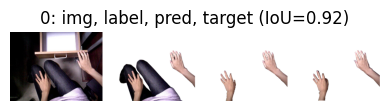

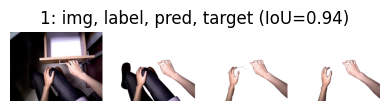

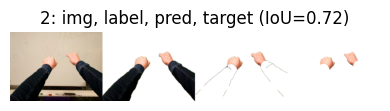

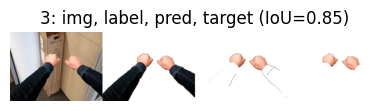

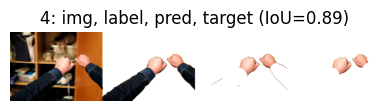

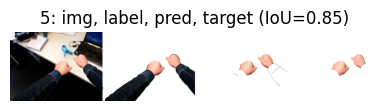

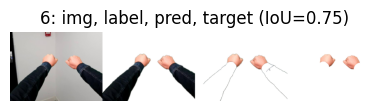

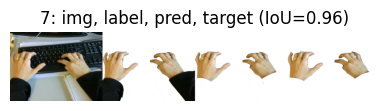

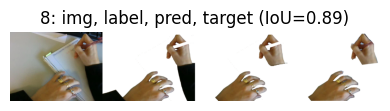

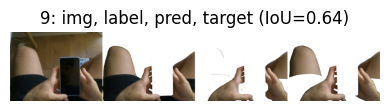

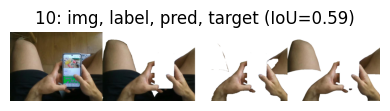

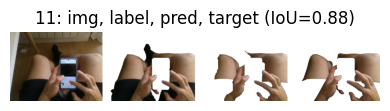

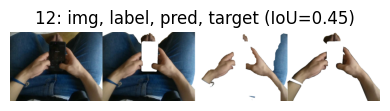

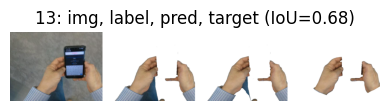

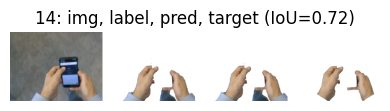

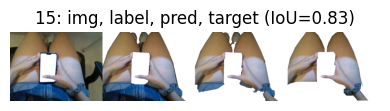

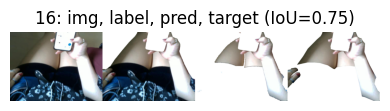

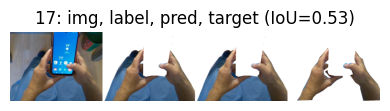

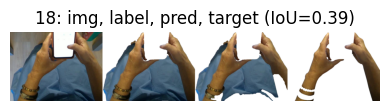

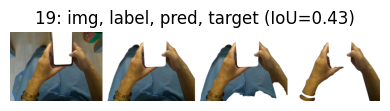

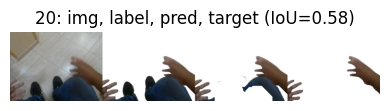

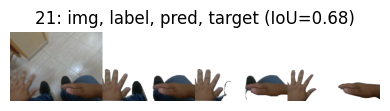

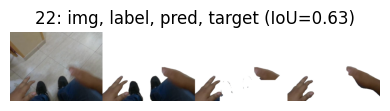

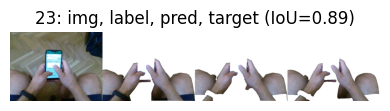

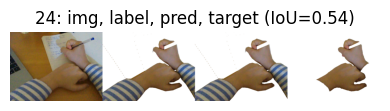

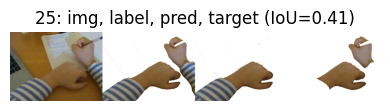

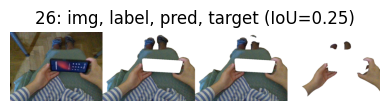

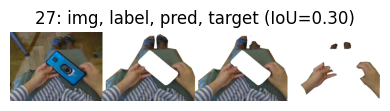

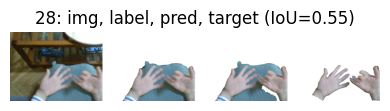

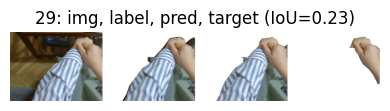

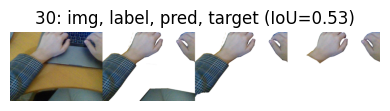

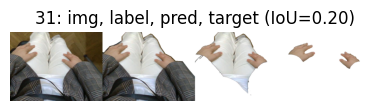

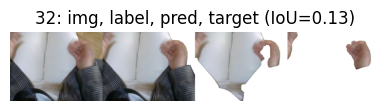

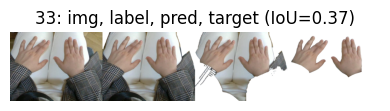

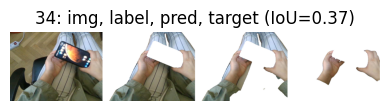

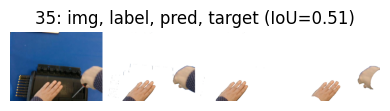

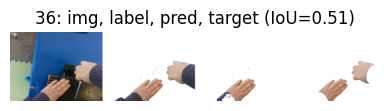

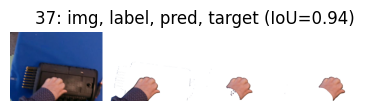

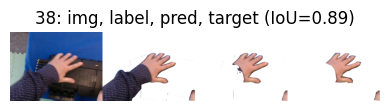

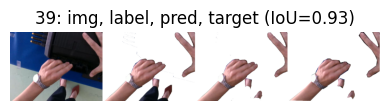

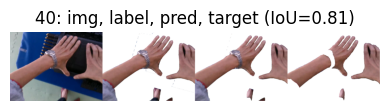

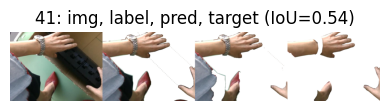

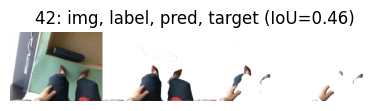

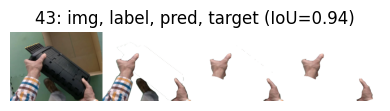

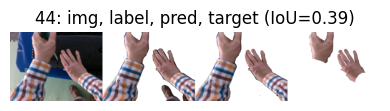

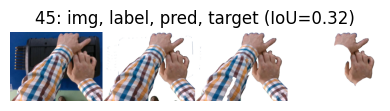

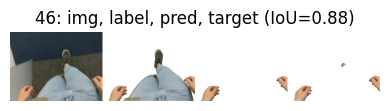

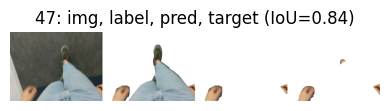

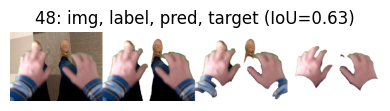

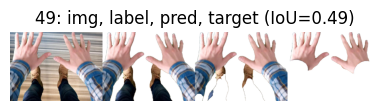

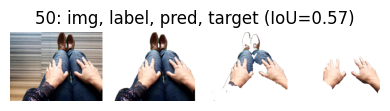

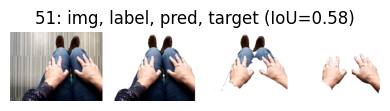

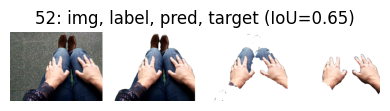

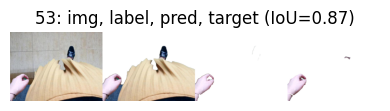

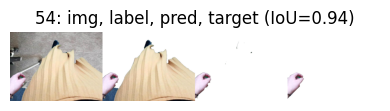

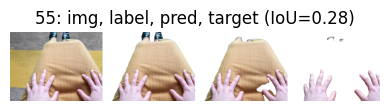

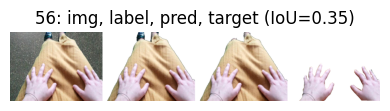

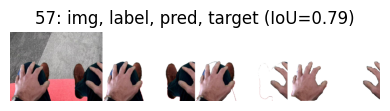

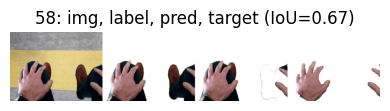

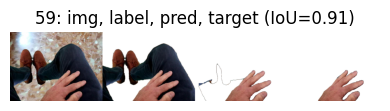

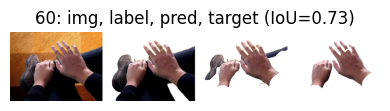

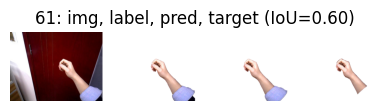

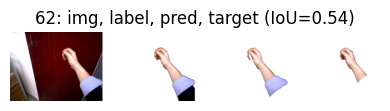

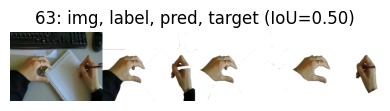

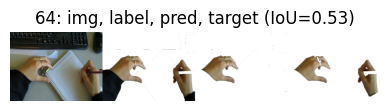

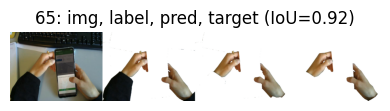

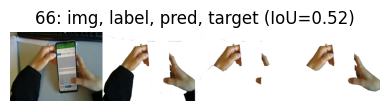

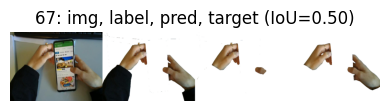

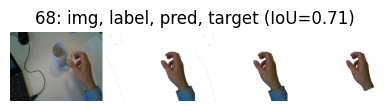

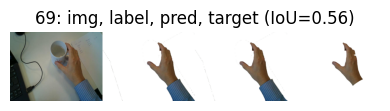

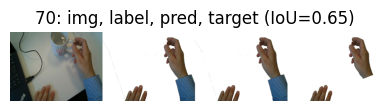

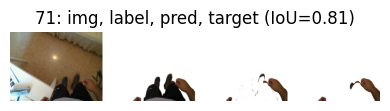

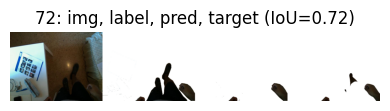

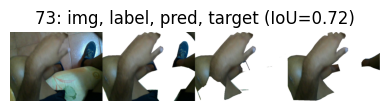

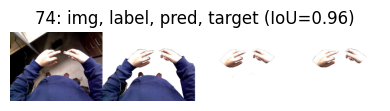

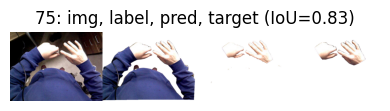

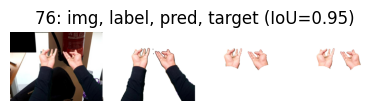

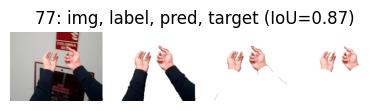

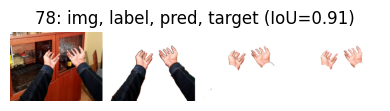

In [175]:
for i, combined_image in enumerate(combined_images):
    display_img(combined_image, title=f"{i}: img, label, pred, target (IoU={IoUs[i]:.2f})")

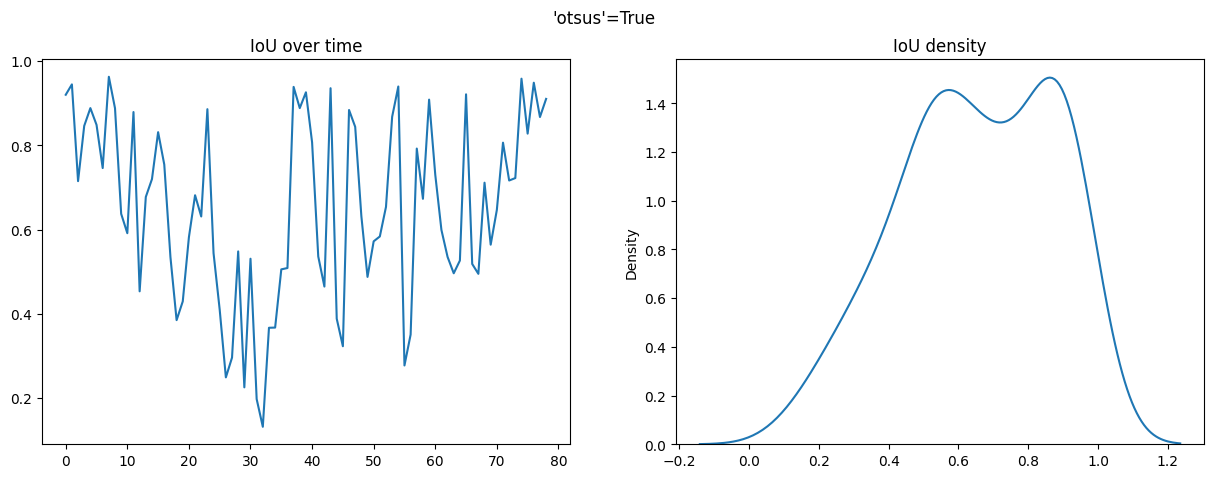

In [176]:
def plot_IoUs(title, IoUs, mode=None, dataset=None, save=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    title = str(title).replace(':', '=').replace(' ', '')[1:-1]
    
    fig.suptitle(title)

    ax[0].plot(IoUs)
    ax[0].set_title("IoU over time")

    sns.kdeplot(IoUs, ax=ax[1])
    ax[1].set_title("IoU density")

    if save:
        os.makedirs(f"../output/{mode}/{dataset}", exist_ok=True)
        plt.savefig(f"../output/{mode}/{dataset}/{title}.png", bbox_inches="tight")
        plt.close()
    else:
        plt.show()

plot_IoUs(setting, IoUs)

### best

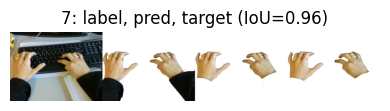

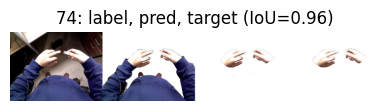

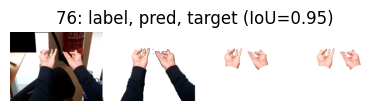

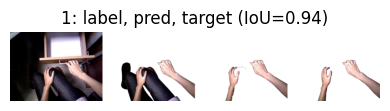

In [177]:
def plot_best(IoUs, combined_images, count=4):
    best = [x for _, x in reversed(sorted(zip(IoUs, range(len(IoUs)))))][:count]
    for img_id in best:
        display_img(combined_images[img_id], title=f"{img_id}: label, pred, target (IoU={IoUs[img_id]:.2f})")
plot_best(IoUs, combined_images)

### worst

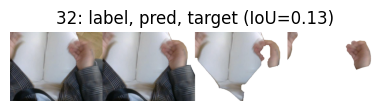

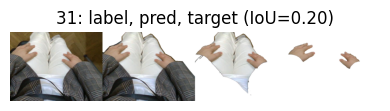

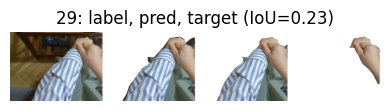

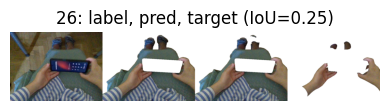

In [178]:
def plot_worst(IoUs, combined_images, count=4):
    worst = [x for _, x in sorted(zip(IoUs, range(len(IoUs))))][:count]

    for img_id in worst:
        display_img(combined_images[img_id], title=f"{img_id}: label, pred, target (IoU={IoUs[img_id]:.2f})")
plot_worst(IoUs, combined_images)

# Comparison

In [ ]:
# settings = [
#     {"baseline": True},
#     {"only_ROI_mask": True},
    
#     {"rgb": True},
#     {"hs": True},
#     {"crcb": True},
#     {"otsus": True},
    
#     {"rgb": True, "hs": True},
#     {"rgb": True, "crcb": True},
#     {"hs": True, "crcb": True},
    
#     {"rgb": True, "otsus": True},
#     {"hs": True, "otsus": True},
#     {"crcb": True, "otsus": True},
    
#     {"rgb": True, "hs": True, "crcb": True},
#     {"rgb": True, "hs": True, "crcb": True, "otsus": True},
    
#     {"madrid": True, "m_cspace": 0},
#     {"madrid": True, "m_cspace": 1},
#     {"madrid": True, "m_cspace": 2},
#     {"madrid": True, "m_cspace": 3},
    
#     {"madrid": True, "m_cspace": 3, "rgb": True},
#     {"madrid": True, "m_cspace": 3, "hs": True},
#     {"madrid": True, "m_cspace": 3, "crcb": True},
#     {"madrid": True, "m_cspace": 3, "otsus": True}
# ]

# modes = ["mask", "cleanup"]
# mode = modes[0]
# datasets = ["THU_READ_RGBD_BODIES", "joint-ep-of-thu-ego", "THU_READ_RGBD"]
# for dataset in datasets:
#     if os.path.exists(f"../output/{mode}/{dataset}_results.txt"):
#         continue
#     print(dataset)
#     images, skins, bodies = load(dataset=dataset)
    
#     results = {}
#     pbar = tqdm(settings)
#     for setting in pbar:
#         pbar.set_description(str(setting))
#         img_ids = range(len(images))
#         if str(setting) not in results:
#             # run
#             predictions, _ = predict(setting, img_ids=img_ids, baseline=setting.get("baseline", False), only_mask=(mode=="mask"), only_body_mask=setting.get("only_body_mask", False), only_ROI_mask=setting.get("only_ROI_mask", False), iter_count=0, verbose=False)
#             combined_images, IoUs, mean_IoU = evaluate(predictions, img_ids=img_ids)

#             # collect
#             results[str(setting)] = {"pred": predictions, "IoUs": IoUs, "mean": mean_IoU, "images": combined_images}
    
#     # create dirs
#     os.makedirs(f"../output/{mode}/", exist_ok=True)
#     # generate results string
#     results_str = ""
#     for setting, result in results.items():
#         results_str += f"mean IoU: {result['mean']:.3f}, IoU count: {len(result['IoUs'])}  --  {setting}\n"
#     with open(f"../output/{mode}/{dataset}_results.txt", "w") as outfile:
#         outfile.write(results_str)
        
#     # sort results
#     results = dict(reversed(sorted(results.items(), key=lambda x: x[1]["mean"])))
    
#     # generate sorted results string
#     results_str = ""
#     for setting, result in results.items():
#         results_str += f"mean IoU: {result['mean']:.3f}, IoU count: {len(result['IoUs'])}  --  {setting}\n"
#     with open(f"../output/{mode}/{dataset}_results_sorted.txt", "w") as outfile:
#         outfile.write(results_str)
        
#     # plot IoU over time
#     for setting, result in results.items():
#         plot_IoUs(setting, result["IoUs"], mode=mode, dataset=dataset, save=True)
        
#     # pickle results
# #     with open(f"../output/{mode}/{dataset}_results.pkl", "wb") as outfile:
# #         pickle.dump(results, outfile)

In [430]:
results = {}

In [431]:
settings = [
    {"baseline": True},
    {"only_ROI_mask": True},
    
    {"rgb": True},
    {"hs": True},
    {"crcb": True},
    {"otsus": True},
    
    {"rgb": True, "hs": True},
    {"rgb": True, "crcb": True},
    {"hs": True, "crcb": True},
    
    {"rgb": True, "otsus": True},
    {"hs": True, "otsus": True},
    {"crcb": True, "otsus": True},
    
    {"rgb": True, "hs": True, "crcb": True},
    {"rgb": True, "hs": True, "crcb": True, "otsus": True},
    
    {"madrid": True, "m_cspace": 0},
    {"madrid": True, "m_cspace": 1},
    {"madrid": True, "m_cspace": 2},
    {"madrid": True, "m_cspace": 3},
    
    {"madrid": True, "m_cspace": 3, "rgb": True},
    {"madrid": True, "m_cspace": 3, "hs": True},
    {"madrid": True, "m_cspace": 3, "crcb": True},
    {"madrid": True, "m_cspace": 3, "otsus": True}
]

modes = ["mask", "cleanup"]
datasets = ["THU_READ_RGBD_BODIES", "joint-ep-of-thu-ego", "THU_READ_RGBD"]

for mode in modes:
    print(mode)
    if mode not in results:
        results[mode] = {}
    for dataset in datasets:
        print(dataset)
        images, skins, bodies = load(dataset=dataset)

        if dataset not in results[mode]:
            results[mode][dataset] = {}

        pbar = tqdm(settings)
        for setting in pbar:
            pbar.set_description(str(setting))
            img_ids = range(len(images))

            if str(setting) in results[mode][dataset] and len(results[mode][dataset][str(setting)]) == len(images):
                continue

            results[mode][dataset][str(setting)] = []
            for img_id in img_ids:
                # get img
                img = get_masked_image(img_id, images, bodies)

                # get skin
                skin = skins[img_id].copy()

                # get body
                body = bodies[img_id].copy()

                try:
                    # only body mask
                    if setting == settings[0]:
                        mask = body
                    else:
                        # get ROI mask
                        ROI_mask = get_ROI_mask(img)
                        assert 1 in np.unique(ROI_mask.flatten())

                        # only ROI mask
                        if setting == settings[1]:
                            mask = ROI_mask
                        else:
                            # get mask
                            mask = get_combined_mask(img, ROI_mask, body, **setting)
                            
                            if mode == "cleanup":
                                # recheck ROIs
                                mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

                                # fill holes
                                mask = fill_mask_holes(mask)                
                except Exception:
                    mask = np.zeros(shape=skin.shape).astype("uint8")
                finally:
                    try:
                        # calculate IoU
                        intersection = np.sum(cv2.bitwise_and(mask, skin) == 1)
                        union = np.sum(cv2.bitwise_or(mask, skin) == 1)
                        IoU = intersection/union if union else 0
                    except Exception:
                        IoU = 0

                    results[mode][dataset][str(setting)].append(IoU)

mask
THU_READ_RGBD_BODIES
loading successful! 35 images, 35 skins, 35 bodies


  0%|          | 0/22 [00:00<?, ?it/s]

joint-ep-of-thu-ego
loading successful! 103 images, 103 skins, 103 bodies


  0%|          | 0/22 [00:00<?, ?it/s]

THU_READ_RGBD
loading successful! 158 images, 158 skins, 158 bodies


  0%|          | 0/22 [00:00<?, ?it/s]

cleanup
THU_READ_RGBD_BODIES
loading successful! 35 images, 35 skins, 35 bodies


  0%|          | 0/22 [00:00<?, ?it/s]

joint-ep-of-thu-ego
loading successful! 103 images, 103 skins, 103 bodies


  0%|          | 0/22 [00:00<?, ?it/s]

THU_READ_RGBD
loading successful! 158 images, 158 skins, 158 bodies


  0%|          | 0/22 [00:00<?, ?it/s]

In [432]:
# write
os.makedirs(f"../output/mask_cleanup/", exist_ok=True)
with open(f"../output/mask_cleanup/results.pkl", "wb") as outfile:
    pickle.dump(results, outfile)

In [417]:
# read
with open(f"../output/grabcut_eval/results.pkl", "rb") as infile:
    results = pickle.load(infile)

In [434]:
for mode, datasets in results.items():
    for dataset, settings in datasets.items():
        for setting, IoUs in settings.items():
            mean_IoU = sum(IoUs)/len(IoUs)
            print(mode, dataset, setting, f"{mean_IoU*100:.1f}")
    print()

mask THU_READ_RGBD_BODIES {'baseline': True} 49.0
mask THU_READ_RGBD_BODIES {'only_ROI_mask': True} 6.3
mask THU_READ_RGBD_BODIES {'rgb': True} 8.3
mask THU_READ_RGBD_BODIES {'hs': True} 7.0
mask THU_READ_RGBD_BODIES {'crcb': True} 37.2
mask THU_READ_RGBD_BODIES {'otsus': True} 71.2
mask THU_READ_RGBD_BODIES {'rgb': True, 'hs': True} 6.9
mask THU_READ_RGBD_BODIES {'rgb': True, 'crcb': True} 36.8
mask THU_READ_RGBD_BODIES {'hs': True, 'crcb': True} 32.7
mask THU_READ_RGBD_BODIES {'rgb': True, 'otsus': True} 70.6
mask THU_READ_RGBD_BODIES {'hs': True, 'otsus': True} 63.9
mask THU_READ_RGBD_BODIES {'crcb': True, 'otsus': True} 67.7
mask THU_READ_RGBD_BODIES {'rgb': True, 'hs': True, 'crcb': True} 32.3
mask THU_READ_RGBD_BODIES {'rgb': True, 'hs': True, 'crcb': True, 'otsus': True} 61.3
mask THU_READ_RGBD_BODIES {'madrid': True, 'm_cspace': 0} 11.6
mask THU_READ_RGBD_BODIES {'madrid': True, 'm_cspace': 1} 38.3
mask THU_READ_RGBD_BODIES {'madrid': True, 'm_cspace': 2} 33.1
mask THU_READ_RGB

#### eval grabcut

In [419]:
results = {}

In [ ]:
# read
with open(f"../output/grabcut_eval/results.pkl", "rb") as infile:
    results = pickle.load(infile)

In [395]:
settings = [
    {"only_ROI_mask": True},
    
    {"rgb": True},
    {"hs": True},
    {"crcb": True},
    {"otsus": True},
    
    {"rgb": True, "hs": True},
    {"rgb": True, "crcb": True},
    {"hs": True, "crcb": True},
    
    {"rgb": True, "otsus": True},
    {"hs": True, "otsus": True},
    {"crcb": True, "otsus": True},
    
    {"rgb": True, "hs": True, "crcb": True},
    {"rgb": True, "hs": True, "crcb": True, "otsus": True},
    
    {"madrid": True, "m_cspace": 0},
    {"madrid": True, "m_cspace": 1},
    {"madrid": True, "m_cspace": 2},
    {"madrid": True, "m_cspace": 3},
    
    {"madrid": True, "m_cspace": 3, "rgb": True},
    {"madrid": True, "m_cspace": 3, "hs": True},
    {"madrid": True, "m_cspace": 3, "crcb": True},
    {"madrid": True, "m_cspace": 3, "otsus": True}
]

mode = "grabcut"
grabcut_iterations = 20
datasets = ["THU_READ_RGBD_BODIES", "joint-ep-of-thu-ego", "THU_READ_RGBD"]
target_lens = [32, 79, 146]
for dataset in datasets:
    print(dataset)
    images, skins, bodies = load(dataset=dataset)
    
    if dataset not in results:
        results[dataset] = {}
        
    pbar = tqdm(settings)
    for setting in pbar:
        pbar.set_description(str(setting))
        
        # skip previously calculated settings        
        if str(setting) in results[dataset] and all([len(IoUs)==len(images) for IoUs in results[dataset][str(setting)].values()]):
            continue
        
        results[dataset][str(setting)] = {}
        for i in range(grabcut_iterations+1):
            results[dataset][str(setting)][i] = []
        
        img_ids = range(len(images))
        for img_id in img_ids:
            # get img
            img = get_masked_image(img_id, images, bodies)

            # get skin
            skin = skins[img_id].copy()
            
            # get body
            body = bodies[img_id].copy()
            
            try:
                # get ROI mask
                ROI_mask = get_ROI_mask(img)
                assert 1 in np.unique(ROI_mask.flatten())

                # only ROI mask
                if setting == settings[0]:
                    mask = ROI_mask
                else:
                    # get mask
                    mask = get_combined_mask(img, ROI_mask, body, **setting)

                    # recheck ROIs
                    mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

                    # fill holes
                    mask = fill_mask_holes(mask)                
            
                # convert mask
                grabcut_mask = np.where((mask==1), 1, 2).astype("uint8")
                grabcut_mask[body == 0] = 0

            except Exception:
                grabcut_mask = np.zeros(shape=skin.shape).astype("uint8")

            # create placeholders
            bgdModel = np.zeros((1,65), np.float64)
            fgdModel = np.zeros((1,65), np.float64)

            # apply grabcut
            for i in range(grabcut_iterations+1):
                try:
                    grabcut_mask, bgdModel, fgdModel = cv2.grabCut(
                            img=img, mask=grabcut_mask, rect=None,
                            bgdModel=bgdModel, fgdModel=fgdModel,
                            iterCount=1, mode=cv2.GC_INIT_WITH_MASK)
                    pred = np.where((grabcut_mask==2)|(grabcut_mask==0), 0, 1).astype("uint8")
                except Exception as e:
                    pred = np.zeros(shape=skin.shape).astype("uint8")
                finally:
                    # calculate IoU
                    intersection = np.sum(cv2.bitwise_and(pred, skin) == 1)
                    union = np.sum(cv2.bitwise_or(pred, skin) == 1)
                    IoU = intersection/union if union else 0
                    
                    results[dataset][str(setting)][i].append(IoU)

THU_READ_RGBD_BODIES
loading successful! 35 images, 35 skins, 35 bodies


  0%|          | 0/21 [00:00<?, ?it/s]

joint-ep-of-thu-ego
loading successful! 103 images, 103 skins, 103 bodies


  0%|          | 0/21 [00:00<?, ?it/s]

THU_READ_RGBD
loading successful! 158 images, 158 skins, 158 bodies


  0%|          | 0/21 [00:00<?, ?it/s]

In [416]:
print(results.keys())

dict_keys([])


In [397]:
# write
os.makedirs(f"../output/grabcut_eval/", exist_ok=True)
with open(f"../output/grabcut_eval/results.pkl", "wb") as outfile:
    pickle.dump(results, outfile)

In [435]:
# read
with open(f"../output/grabcut_eval/results.pkl", "rb") as infile:
    results = pickle.load(infile)

In [399]:
for dataset, result in results.items():
    for setting, iter_counts in result.items():
        for iter_count, IoUs in iter_counts.items():
            print(dataset, setting, iter_count, len(IoUs))

THU_READ_RGBD_BODIES {'only_ROI_mask': True} 0 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 1 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 2 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 3 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 4 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 5 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 6 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 7 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 8 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 9 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 10 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 11 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 12 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 13 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 14 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 15 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 16 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 17 35
THU_READ_RGBD_BODIES {'only_ROI_mask': True} 18 35
THU_READ_RGBD_BODIES {'only_ROI_mask': Tr

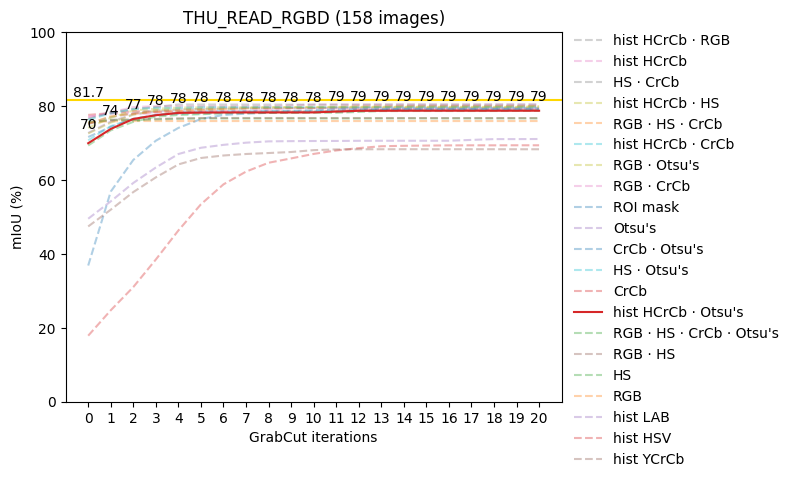

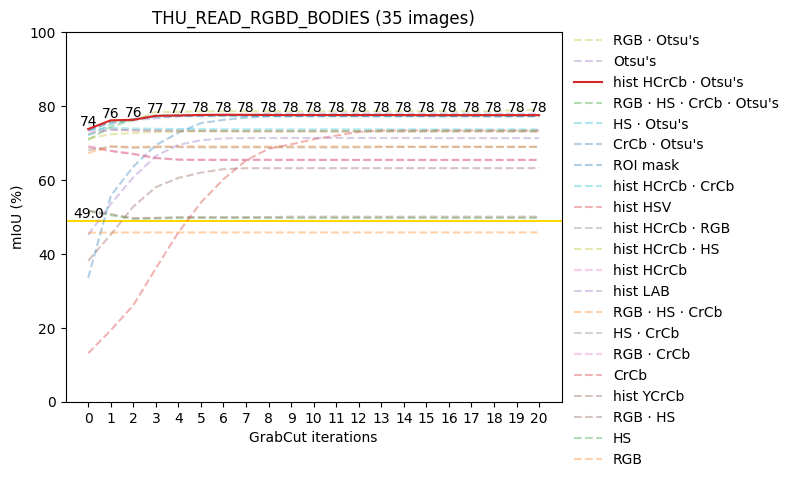

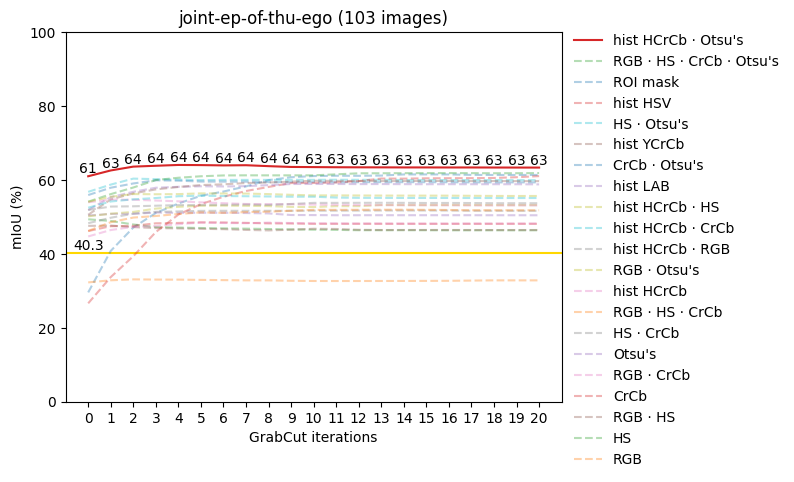

In [457]:
datasets = ["THU_READ_RGBD", "THU_READ_RGBD_BODIES", "joint-ep-of-thu-ego"]
img_counts = [158, 35, 103]
line_labels = ["ROI mask", "RGB", "HS", "CrCb", "Otsu's", "RGB ⋅ HS", "RGB ⋅ CrCb", "HS ⋅ CrCb", "RGB ⋅ Otsu's", "HS ⋅ Otsu's", "CrCb ⋅ Otsu's", "RGB ⋅ HS ⋅ CrCb", "RGB ⋅ HS ⋅ CrCb ⋅ Otsu's", "hist HSV", "hist LAB", "hist YCrCb", "hist HCrCb", "hist HCrCb ⋅ RGB", "hist HCrCb ⋅ HS", "hist HCrCb ⋅ CrCb", "hist HCrCb ⋅ Otsu's"]
baselines = [81.7, 49.0, 40.3]

for dataset in datasets:
    # plot baseline
    plt.axhline(y=baselines[datasets.index(dataset)], color="gold")
    plt.text(x=0, y=baselines[datasets.index(dataset)], s=baselines[datasets.index(dataset)], ha="center", va="bottom")
    
    # plot settings
    label_i = 0
    last_IoUs = []
    for setting, iter_counts in results[dataset].items():
        mean_IoUs = []
        for i, IoUs in iter_counts.items():
            mean_IoU = sum(IoUs)/len(IoUs)
            mean_IoUs.append(mean_IoU*100)
        last_IoUs.append(mean_IoUs[-1])
        if line_labels[label_i] == "hist HCrCb ⋅ Otsu's":
            plt.plot(mean_IoUs, color="tab:red", label=line_labels[label_i])
            for i, mean_IoU in enumerate(mean_IoUs):
                plus_val = 0
                if dataset == "THU_READ_RGBD":
                    plus_val += 2
                    if i == 0:
                        plus_val += 1
                    elif i == 1:
                        plus_val += 1
                plt.text(x=i, y=mean_IoU + plus_val, s=f"{mean_IoU:.0f}", ha="center", va="bottom")
        else:
            plt.plot(mean_IoUs, alpha=0.35, linestyle="--", label=line_labels[label_i])
        label_i += 1
        
#     print(dataset)
#     for line_label, last_IoU in zip(line_labels, last_IoUs):
#         print(line_label, f"{last_IoU:.1f}")
        
    plt.title(f"{dataset} ({img_counts[datasets.index(dataset)]} images)")
    plt.xlabel("GrabCut iterations")
    plt.ylabel("mIoU (%)")
    plt.xticks(range(21))
    plt.ylim(0, 100)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = reversed(sorted(handles, key=lambda x: last_IoUs[handles.index(x)]))
    labels = reversed(sorted(labels, key=lambda x: last_IoUs[labels.index(x)]))
    plt.legend(handles, labels, bbox_to_anchor=(1, 1.03), loc="upper left", frameon=False)
    
    plt.show()

#### save images

In [32]:
output_dir = "..\output"
final_image_dir = os.path.join(output_dir, "final", "images")
final_preds_dir = os.path.join(output_dir, "final", "preds")
os.makedirs(final_image_dir, exist_ok=True)
os.makedirs(final_preds_dir, exist_ok=True)

settings = [
    {"madrid": True, "m_cspace": 3, "otsus": True}
]

mode = "grabcut"
datasets = ["THU_READ_RGBD_BODIES", "joint-ep-of-thu-ego"]
target_lens = [32, 79, 146]
i = 0
for dataset in datasets:
    print(dataset)
    images, skins, bodies = load(dataset=dataset)
    for setting in settings:
        print(setting)
        img_ids = range(len(images))
        pbar = tqdm(img_ids)
        for img_id in pbar:
            # get img
            img = get_masked_image(img_id, images, bodies)

            # get skin
            skin = skins[img_id].copy()
            
            # get body
            body = bodies[img_id].copy()
            
            try:
                # get ROI mask
                ROI_mask = get_ROI_mask(img)
                assert 1 in np.unique(ROI_mask.flatten())

                # only ROI mask
                if setting == settings[0]:
                    mask = ROI_mask
                else:
                    # get mask
                    mask = get_combined_mask(img, ROI_mask, body, **setting)

                    # recheck ROIs
                    mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

                    # fill holes
                    mask = fill_mask_holes(mask)                
            
                # convert mask
                grabcut_mask = np.where((mask==1), 1, 2).astype("uint8")
                grabcut_mask[body == 0] = 0

            except Exception:
                grabcut_mask = np.zeros(shape=skin.shape).astype("uint8")

            # create placeholders
            bgdModel = np.zeros((1,65), np.float64)
            fgdModel = np.zeros((1,65), np.float64)

            # apply grabcut
            try:
                grabcut_mask, bgdModel, fgdModel = cv2.grabCut(
                        img=img, mask=grabcut_mask, rect=None,
                        bgdModel=bgdModel, fgdModel=fgdModel,
                        iterCount=20, mode=cv2.GC_INIT_WITH_MASK)
                pred = np.where((grabcut_mask==2)|(grabcut_mask==0), 0, 1).astype("uint8")
            except Exception as e:
                pred = np.zeros(shape=skin.shape).astype("uint8")
            finally:
                img = cv2.cvtColor(images[img_id], cv2.COLOR_BGR2RGB)
                mask = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
                
                # save image
                plt.figure()
                plt.axis("off")
                plt.imshow(img)
                plt.tight_layout()
#                 plt.show()
                plt.savefig(os.path.join(final_image_dir, f"{i}.png"), bbox_inches="tight")
                plt.close()
                # save masked image
                plt.figure()
                plt.axis("off")
                plt.imshow(img*mask)
                plt.tight_layout()
#                 plt.show()
                plt.savefig(os.path.join(final_preds_dir, f"{i}.png"), bbox_inches="tight")
                plt.close()
                i += 1

THU_READ_RGBD_BODIES
loading successful! 35 images, 35 skins, 35 bodies
{'madrid': True, 'm_cspace': 3, 'otsus': True}


  0%|          | 0/35 [00:00<?, ?it/s]

joint-ep-of-thu-ego
loading successful! 103 images, 103 skins, 103 bodies
{'madrid': True, 'm_cspace': 3, 'otsus': True}


  0%|          | 0/103 [00:00<?, ?it/s]

In [33]:
def overlay_two_images(image, overlay, ignore_color=[0, 0, 0]):
    ignore_color = np.asarray(ignore_color)
    mask = (overlay==ignore_color).all(-1, keepdims=True)
    out = np.where(mask, image, (image * 0.5 + overlay * 0.5).astype(image.dtype))
    return out

In [36]:
output_dir = "..\output"
final_overlay_dir = os.path.join(output_dir, "overlay")
os.makedirs(final_overlay_dir, exist_ok=True)

settings = [
    {"madrid": True, "m_cspace": 3, "otsus": True}
]

mode = "grabcut"
datasets = ["THU_READ_RGBD", "joint-ep-of-thu-ego"]
target_lens = [32, 79, 146]
i = 0
for dataset in datasets:
    print(dataset)
    images, skins, bodies = load(dataset=dataset)
    for setting in settings:
        print(setting)
        img_ids = range(len(images))
        pbar = tqdm(img_ids)
        for img_id in pbar:
            # get img
            img = get_masked_image(img_id, images, bodies)

            # get skin
            skin = skins[img_id].copy()
            
            # get body
            body = bodies[img_id].copy()
            
            try:
                # get ROI mask
                ROI_mask = get_ROI_mask(img)
                assert 1 in np.unique(ROI_mask.flatten())

                # only ROI mask
                if setting == settings[0]:
                    mask = ROI_mask
                else:
                    # get mask
                    mask = get_combined_mask(img, ROI_mask, body, **setting)

                    # recheck ROIs
                    mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

                    # fill holes
                    mask = fill_mask_holes(mask)                
            
                # convert mask
                grabcut_mask = np.where((mask==1), 1, 2).astype("uint8")
                grabcut_mask[body == 0] = 0

            except Exception:
                grabcut_mask = np.zeros(shape=skin.shape).astype("uint8")

            # create placeholders
            bgdModel = np.zeros((1,65), np.float64)
            fgdModel = np.zeros((1,65), np.float64)

            # apply grabcut
            try:
                grabcut_mask, bgdModel, fgdModel = cv2.grabCut(
                        img=img, mask=grabcut_mask, rect=None,
                        bgdModel=bgdModel, fgdModel=fgdModel,
                        iterCount=20, mode=cv2.GC_INIT_WITH_MASK)
                pred = np.where((grabcut_mask==2)|(grabcut_mask==0), 0, 1).astype("uint8")
            except Exception as e:
                pred = np.zeros(shape=skin.shape).astype("uint8")
            finally:
                img = cv2.cvtColor(images[img_id], cv2.COLOR_BGR2RGB).astype("uint8")
                mask = cv2.merge([pred*0, pred*255, pred*0]).astype("uint8")
                overlay = overlay_two_images(img, mask)
                
                # save overlay
                plt.figure()
                plt.axis("off")
                plt.imshow(overlay)
                plt.tight_layout()
#                 plt.show()
                plt.savefig(os.path.join(final_overlay_dir, f"{i}.png"), bbox_inches="tight")
                plt.close()
                i += 1

THU_READ_RGBD
loading successful! 158 images, 158 skins, 158 bodies
{'madrid': True, 'm_cspace': 3, 'otsus': True}


  0%|          | 0/158 [00:00<?, ?it/s]